In [108]:
import numpy as np

#from assets.keras.keras.datasets import shapes_3d
from assets.keras.keras.preprocessing.image import ImageDataGenerator
from assets.keras.keras.models import Sequential
from assets.keras.keras.layers.core import Dense, Dropout, Activation, Flatten
from assets.keras.keras.layers.convolutional import Convolution3D, MaxPooling3D, ZeroPadding3D
from assets.keras.keras.layers.normalization import BatchNormalization
from assets.keras.keras.optimizers import SGD, RMSprop, Adam
from assets.keras.keras.utils import np_utils, generic_utils
from assets.keras.keras.regularizers import l2
from assets.keras.keras.callbacks import EarlyStopping
import theano
import matplotlib.pyplot as plt
import math
from assets.vis_utils import *
%matplotlib nbagg
%load_ext autoreload
%autoreload 2

#load dataset from gen_dataset
import cPickle as pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
from assets.gen_motion import gen_dataset
import math

angles = [0,math.pi/4,math.pi/2,math.pi*3/4,math.pi,math.pi*5/4,math.pi*3/2,math.pi*7/4]
#gen_dataset(size, N, obj_type, obj_theta, obj_vel, types, velocity, theta, coherence, dots, directions(opt))
X_train,Y_train,X_val,Y_val,X_test,Y_test = gen_dataset((16,32,32),50,None,['translate'],[1],angles,[1],[150],[0])

Y_train[:,2] = Y_train[:,2]/math.pi*4
Y_val[:,2] = Y_val[:,2]/math.pi*4
Y_test[:,2] = Y_test[:,2]/math.pi*4

##### WARNING ##########################################
# CHANGE THIS CODE IF YOU CHANGE THE NUMBER OF CLASSES #
######################################## WARNING #######
nb_classes = len(eight_angles)
Y_train = np_utils.to_categorical(Y_train[:,2]-1, nb_classes)
Y_val = np_utils.to_categorical(Y_val[:,2]-1,nb_classes)
Y_test = np_utils.to_categorical(Y_test[:,2]-1, nb_classes)

<IPython.core.display.Javascript object>


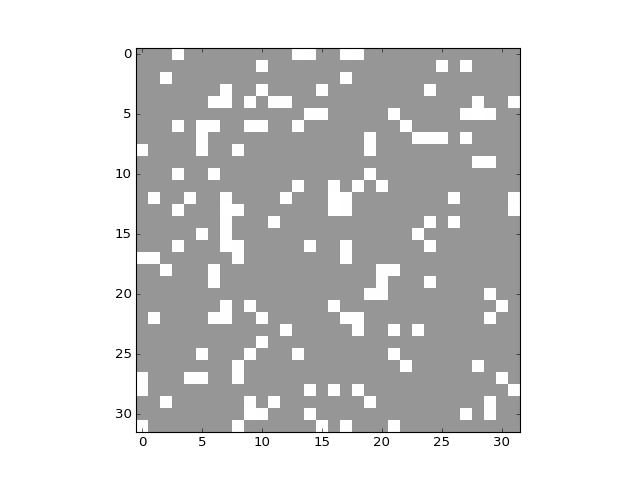

In [20]:
visualize_matrix(X_train[360,0,:,:,:],interval_len=50)

In [59]:

#(X_train, Y_train),(X_test, Y_test) = shapes_3d.load_data(test_split=test_split,
#                                                          dataset_size=dataset_size,
#                                                          patch_size=patch_size)

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print('X_val shape:', X_val.shape)
print('Y_val shape:', Y_val.shape)
print('X_test shape:', X_test.shape)
print('Y_test shape:', Y_test.shape)
print(X_train.shape[0], 'train samples')
print(X_val.shape[0], 'val samples')
print(X_test.shape[0], 'test samples')



('X_train shape:', (400, 1, 16, 32, 32))
('Y_train shape:', (400, 8))
('X_val shape:', (40, 1, 16, 32, 32))
('Y_val shape:', (40, 8))
('X_test shape:', (40, 1, 16, 32, 32))
('Y_test shape:', (40, 8))
(400, 'train samples')
(40, 'val samples')
(40, 'test samples')


In [114]:
def save_model(model):
    pickle.dump( favorite_color, open( "~/", "wb" ) )

def load_model(model):
    pickle.load( open("~/", "rb"))

def build_eval(params,r,l,nb_f,nb_p,nb_c,data,model):
    batch_size, nb_classes, nb_epoch = params
    X_train,Y_train,X_val,Y_val,X_test,Y_test = data
    if model==None:
        model = Sequential()
        model.add(ZeroPadding3D((0,1,1),input_shape=(1,16,32,32)))
        model.add(Convolution3D(nb_f[0],len_conv_dim1=1, len_conv_dim2=nb_c[0], len_conv_dim3=nb_c[0], border_mode='valid',
                                 activation='relu', W_regularizer=l2(r),dim_ordering='th'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(1, nb_p[0], nb_p[0])))
        #model.add(Dropout(0.5))
        model.add(ZeroPadding3D((1,1,1)))
        model.add(Convolution3D(nb_f[1],len_conv_dim1=nb_c[1], len_conv_dim2=nb_c[1], len_conv_dim3=nb_c[1], border_mode='valid',
                                activation='relu', W_regularizer=l2(r)))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(nb_p[1], nb_p[1], nb_p[1])))
        #model.add(Dropout(0.5))
        #model.add(ZeroPadding3D((1,1,1)))
        model.add(Convolution3D(nb_f[2],len_conv_dim1=nb_c[2], len_conv_dim2=nb_c[2], len_conv_dim3=nb_c[2], border_mode='valid',
                                activation='relu', W_regularizer=l2(r)))
        model.add(BatchNormalization())
        model.add(Flatten())
        #model.add(Dropout(0.5))
        #model.add(Dense(4, init='normal', activation='relu', W_regularizer=l2(reg)))
        model.add(Dense(nb_classes, init='normal', W_regularizer=l2(r)))
        model.add(Activation('softmax'))

        #Adam
        sgd = RMSprop(lr=l, decay=1e-6, momentum=0.9, nesterov=True)
        model.compile(loss='categorical_crossentropy', optimizer=sgd, class_mode='categorical')

        
    # control the model to crash early if nothing happens
    earlyStopping=EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='auto')

    hist = model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch, show_accuracy=True, verbose=1,
              validation_data=(X_val,Y_val), callbacks=[earlyStopping])
    scoretr = model.evaluate(X_train, Y_train, batch_size=batch_size, show_accuracy=True)
    scoreva = model.evaluate(X_val, Y_val, batch_size=batch_size, show_accuracy=True)
    return (model, hist, scoretr, scoreva)

In [ ]:
iters = 1

data = (X_train,Y_train,X_val,Y_val,X_test,Y_test)

best_model = None
best_val = 0
best_hist = None
best_scoretr = None
best_scoreva = None
best_params = None


batch_size = 20
nb_epoch = 90

params = (batch_size,nb_classes,nb_epoch)

for i in range(iters):
    # for each iteration
    print 'Training model #: ', i+1
    nb_filters = [4,4,4] #[2**np.random.randint(2,3),2**np.random.randint(2,3),2**np.random.randint(2,3)]
    nb_pool = [2,2]
    nb_conv = [3,3,3]
    reg = 1e-3#10**(-1*np.random.rand()*2)
    l_r = 1e-4#10**(-1*(np.random.rand()*2+4))
    model,hist,scoretr,scoreva = build_eval(params,reg,l_r,nb_filters,nb_pool,nb_conv,data,None)
    if scoreva[1] > best_val:
        best_model = model
        best_hist = hist
        best_scoretr = scoretr
        best_scoreva = scoreva
        best_val = scoreva[1]
        best_params = (reg,l_r,nb_filters,nb_pool,nb_conv)
    

In [113]:
scorete = best_model.evaluate(X_test, Y_test, batch_size=20, show_accuracy=True)

print('Train loss:', best_scoretr[0])
print('Train accuracy:', best_scoretr[1])
print('Val loss:', best_scoreva[0])
print('Val accuracy:', best_scoreva[1])
print('Test loss:', scorete[0])
print('Test accuracy:', scorete[1])

print best_params

40/40 [==============================] - 0s     
('Train loss:', 2.0769324779510496)
('Train accuracy:', 0.14249999999999999)
('Val loss:', 2.0816932916641235)
('Val accuracy:', 0.14999999999999999)
('Test loss:', 2.0782582759857178)
('Test accuracy:', 0.125)
(0.001, 0.0001, [4, 4, 4], [2, 2], [3, 3, 3])


<IPython.core.display.Javascript object>


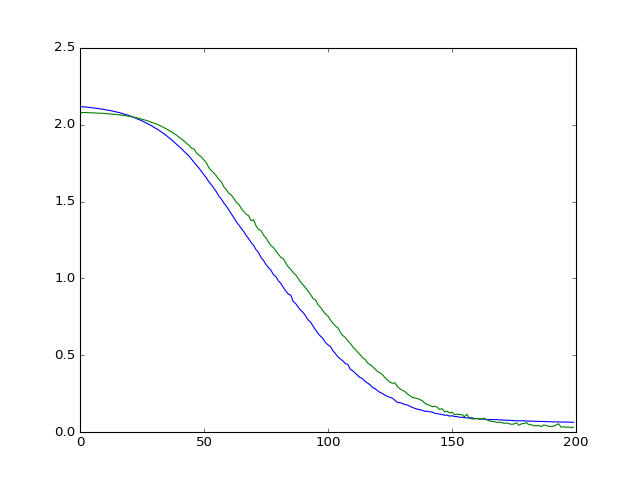

In [68]:
#print best_model.history.history.keys()
plt.plot(np.asarray(best_model.history.history['loss'])[0:500])
plt.plot(np.asarray(best_model.history.history['val_loss'])[0:500])

In [64]:
# (#outputs,#inputs,time,x-dir,y-dir)
for layer in model.layers:
    g = layer.get_config()
    h = layer.get_weights()
    #print g
    for hi in h:
        #print hi
        print hi.shape

(4, 1, 1, 3, 3)
(4,)
(32,)
(32,)
(32,)
(32,)
(4, 4, 3, 3, 3)
(4,)
(16,)
(16,)
(16,)
(16,)
(4, 4, 3, 3, 3)
(4,)
(6,)
(6,)
(6,)
(6,)
(864, 8)
(8,)


In [87]:
# Build a low coherence dataset to test performance on low coherence
angles = [0,math.pi/4,math.pi/2,math.pi*3/4,math.pi,math.pi*5/4,math.pi*3/2,math.pi*7/4]
#gen_dataset(size, N, obj_type, obj_theta, obj_vel, types, velocity, theta, coherence, dots, directions(opt))
X_train_low,Y_train_low,X_val_low,Y_val_low,X_test_low,Y_test_low = gen_dataset((16,32,32),5,None,['translate'],[0],angles,[0],[150],[0])

Y_train_low[:,2] = Y_train_low[:,2]/math.pi*4
Y_val_low[:,2] = Y_val_low[:,2]/math.pi*4
Y_test_low[:,2] = Y_test_low[:,2]/math.pi*4

##### WARNING ##########################################
# CHANGE THIS CODE IF YOU CHANGE THE NUMBER OF CLASSES #
######################################## WARNING #######
nb_classes = len(angles)
Y_train_low_ = np_utils.to_categorical(Y_train_low[:,2]-1, nb_classes)
Y_val_low_ = np_utils.to_categorical(Y_val_low[:,2]-1,nb_classes)
Y_test_low_ = np_utils.to_categorical(Y_test_low[:,2]-1, nb_classes)

<IPython.core.display.Javascript object>


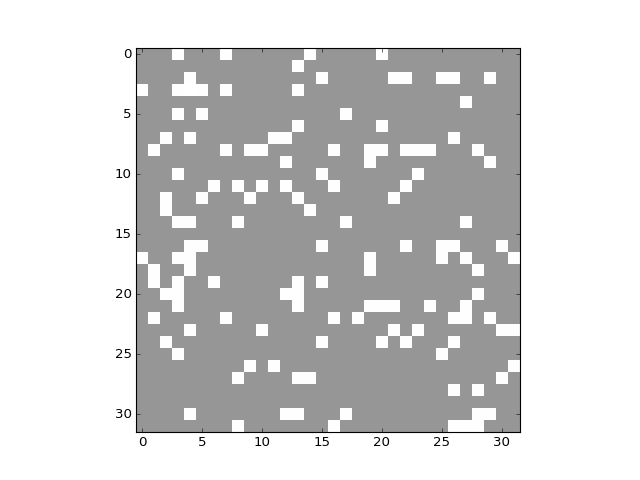

In [83]:
visualize_matrix(X_train_low[1,0,:,:,:])

In [106]:
score_low_train = best_model.evaluate(X_train_low, Y_train_low, batch_size=20, show_accuracy=True)

print('Train loss:', best_scoretr[0])
print('Train accuracy:', best_scoretr[1])
#print('Val loss:', best_scoreva[0])
#print('Val accuracy:', best_scoreva[1])
#print('Test loss:', scorete[0])
#print('Test accuracy:', scorete[1])

ValueError: Input dimension mis-match. (input[0].shape[1] = 6, input[1].shape[1] = 8)
Apply node that caused the error: Elemwise{Composite{(i0 * log(clip((i1 / i2), i3, i4)))}}[(0, 1)](<TensorType(float32, matrix)>, SoftmaxWithBias.0, InplaceDimShuffle{0,x}.0, TensorConstant{(1, 1) of 1e-07}, TensorConstant{(1, 1) of 1.0})
Toposort index: 240
Inputs types: [TensorType(float32, matrix), TensorType(float32, matrix), TensorType(float32, col), TensorType(float32, (True, True)), TensorType(float32, (True, True))]
Inputs shapes: [(20, 6), (20, 8), (20, 1), (1, 1), (1, 1)]
Inputs strides: [(24, 4), (32, 4), (4, 4), (4, 4), (4, 4)]
Inputs values: ['not shown', 'not shown', 'not shown', array([[  1.00000001e-07]], dtype=float32), array([[ 0.99999988]], dtype=float32)]
Outputs clients: [[Sum{axis=[1], acc_dtype=float64}(Elemwise{Composite{(i0 * log(clip((i1 / i2), i3, i4)))}}[(0, 1)].0)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [89]:
class_out = best_model.predict_classes(X_train_low,batch_size=20)


40/40 [==============================] - 0s     


In [90]:
class_out

array([7, 7, 5, 5, 5, 7, 5, 7, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4, 5, 7, 5, 5,
       7, 5, 5, 7, 7, 7, 7, 5, 7, 5, 7, 7, 5, 7, 7, 7, 7])

In [101]:
print Y_train_low[:,2].astype('uint32')

[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 5 5 5 5 5 6 6 6 6 6 7 7
 7 7 7]
